<a href="https://www.kaggle.com/code/naumanrafique12/ccap-99-accuracy?scriptVersionId=211330425" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-credit-card-dataset-for-machine-exam/credit_record.csv
/kaggle/input/a-credit-card-dataset-for-machine-exam/application_record.csv


# Step 1

# Data PreProcessing

# Reading DataSet And Removing Duplicates

In [2]:
credit_df = pd.read_csv("/kaggle/input/a-credit-card-dataset-for-machine-exam/credit_record.csv")
application_df = pd.read_csv("/kaggle/input/a-credit-card-dataset-for-machine-exam/application_record.csv")
application_df = application_df.drop_duplicates(subset='ID', keep='first')

Filling missing Values with Unknown because there're many missing values

In [3]:
application_df['OCCUPATION_TYPE']=application_df['OCCUPATION_TYPE'].fillna('Unknown')

# Making Features from Credit Dataset

**Feature Engineering:**




         -   Making new features like Max, Credit Count on time, Count of no Credit, Paid in Time

In [4]:
def aggregate_credit_data(credit_df):
    
    credit_features = credit_df.groupby('ID').agg(
        total_paid_in_full=('STATUS', lambda x: (x == 'C').sum()),
        total_on_time=('STATUS', lambda x: (x == '0').sum()),
        total_no_credit=('STATUS', lambda x: (x == 'X').sum()),
        total_late=('STATUS', lambda x: sum(x.isin(['1', '2', '3', '4', '5']))),
        max_delay=('STATUS', lambda x: max([int(i) for i in x if i.isdigit()], default=0))
    ).reset_index()
    return credit_features

credit_features = aggregate_credit_data(credit_df)

# Objective:

The target varaible has the following values:

C: paid off that month


X: no loan for the month


0: 1-29 days past due


1: 30-59 days past due


2: 60-89 days overdue


3: 90-119 days overdue


4: 120-149 days overdue


5: Overdue or bad debts, write-offs for more than 150 days -->


C,X,0 are very Good Customers


1 is Good customers


2,3 are not Bad Customers


4 Bad Customers


5 Very Bad Customers

In [5]:
def classify_client(status):
    if status in ['C', 'X', '0']:
        return 'Very Good'
    elif status in ['1']:
        return 'Good'
    elif status in ['2', '3']: 
        return 'Not Bad'
    elif status in ['4']:
        return 'Bad'
    elif status in ['5']:
        return 'Very Bad'
    else:
        return 'Unknown'
credit_data = pd.merge(credit_df, credit_features, on='ID', how='inner')

credit_data['STATUS'] = credit_data['STATUS'].apply(classify_client)


# Step 2: Merge datasets


In [6]:
credit_data['MONTHS_BALANCE'] = credit_df['MONTHS_BALANCE']
final_df = pd.merge(application_df, credit_data, on='ID', how='inner')

# Renaming the Features

In [7]:

final_df.rename(columns={
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_property',
    'CNT_CHILDREN': 'children',
    'AMT_INCOME_TOTAL': 'income',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'FLAG_MOBIL': 'mobile',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email',
    'CNT_FAM_MEMBERS': 'family_members',
    'MONTHS_BALANCE': 'months_balance',
    'STATUS' : 'status',
    'DAYS_BIRTH' : 'age_in_days',
    'DAYS_EMPLOYED' : 'employment_in_days'

} , inplace=True)


# Step 3: Feature engineering


In [8]:

final_df['age'] = abs(final_df['age_in_days']) // 365   
final_df['employment_in_days'] = abs(final_df['employment_in_days']) // 365   
final_df.drop(['age_in_days','ID'], axis=1, inplace=True)

# Satistical Analysis:

     - Applying the ANNOVA & Chi-Square test to retain the significant Features which have some relation with output column

In [9]:
import pandas as pd
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def find_significant_features(df, target_column, numerical_features, categorical_features, alpha=0.05):
    
    significant_numerical = []
    significant_categorical = []
    target_classes = df[target_column].nunique()  # Number of unique classes in the target column

    for feature in numerical_features:
        if target_classes == 2:
    
            groups = [df[df[target_column] == cls][feature] for cls in df[target_column].unique()]
            f_stat, p_value = f_oneway(*groups)
        else:
           
            formula = f"{feature} ~ C({target_column})"
            model = ols(formula, data=df).fit()
            anova_results = anova_lm(model)
            p_value = anova_results['PR(>F)'][0]  # p-value from the results

        if p_value < alpha:
            significant_numerical.append(feature)

    # Process categorical features
    for feature in categorical_features:
        contingency_table = pd.crosstab(df[feature], df[target_column])
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        if p_value < alpha:
            significant_categorical.append(feature)
    significant_categorical.extend(['status','months_balance'])
    
    significant_numerical.extend(significant_categorical)
    return significant_numerical


numerical_features = ['income', 'employment_in_days', 'age', 'total_paid_in_full', 'total_on_time', 'total_no_credit', 'total_late', 'max_delay']
categorical_features = ['gender', 'own_car', 'own_property', 'children', 'income_type', 'education', 'family_status', 'housing_type', 'mobile', 'work_phone', 'phone', 'email', 'OCCUPATION_TYPE', 'family_members']
target_column = 'status'

important_features = find_significant_features(final_df, target_column, numerical_features, categorical_features)
final_df=final_df[important_features]

/tmp/ipykernel_23/3842977347.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_results['PR(>F)'][0]  # p-value from the results
/tmp/ipykernel_23/3842977347.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_results['PR(>F)'][0]  # p-value from the results
/tmp/ipykernel_23/3842977347.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_results['PR(>F)'][0]  # p-value from the res

# Correlation

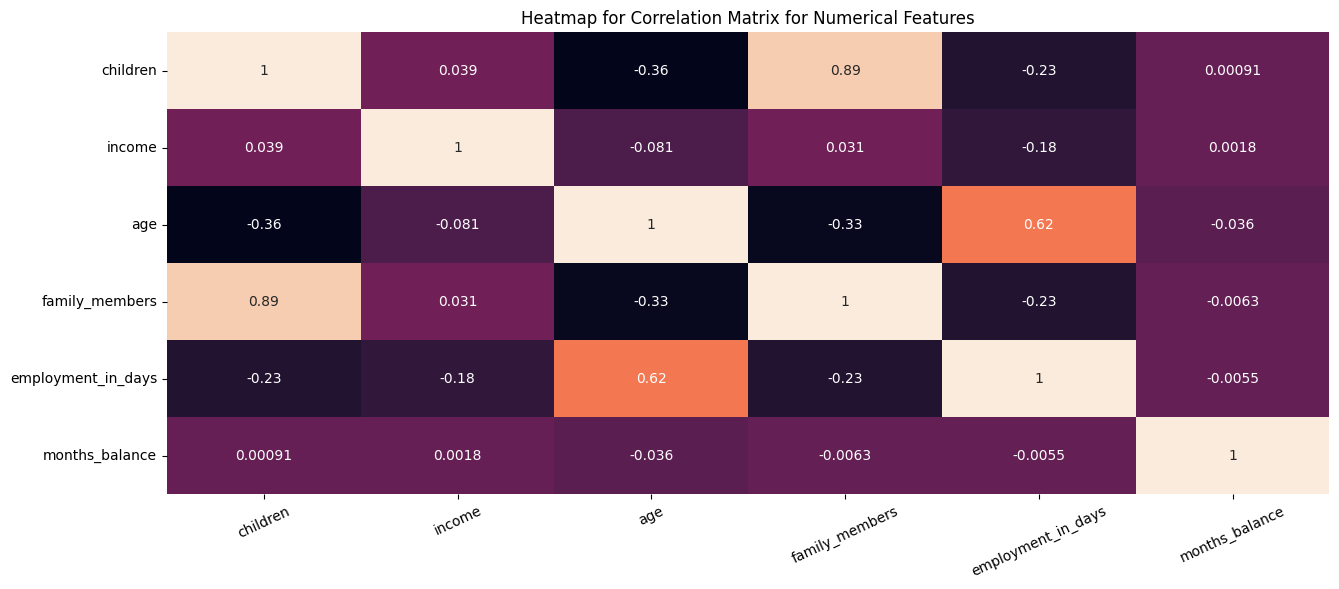

In [10]:
plt.figure(figsize=(15, 6))
# plotting the heatmap
sns.heatmap(final_df[['children', 'income', 'age',  'family_members', 'employment_in_days', 'months_balance']].corr(), annot=True , cbar=False) 
# defining the title and rotation of x-axis labels
plt.xticks(rotation=25)
plt.title('Heatmap for Correlation Matrix for Numerical Features')
plt.show()

# Multi Collinerity

Removing those columns who are highly correlated over 80% threshold

In [11]:
corr_matrix = final_df.select_dtypes(exclude='object').corr()
to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)
final_df = final_df.drop(columns=list(to_drop))

# Splitting Dataset into Input(X) & Output(Y)

In [12]:
X=final_df.drop(['status'],axis=1)
y = final_df['status'] # Assume that y is our dependent variable
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline

Making a Pipeline to deal with Numerical & Categorical Column at a time

- Nominal Columns are dealing with One Hot Encoder

- Ordinal Column like Education is dealing with Ordinal Encoder

- Standard Scaler to scale the values using Standard Scaler

In [13]:

categorical_columns = X_train.select_dtypes(include="object").columns.to_list()
categorical_columns.remove("education")
numerical_columns = X_train.select_dtypes(exclude="object").columns.to_list()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')  # For categorical columns
scaler = StandardScaler()  # For numerical columns
oe = OrdinalEncoder(categories=[['Lower secondary', 'Incomplete higher', "Secondary / secondary special", 'Higher education', 'Academic degree']])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, categorical_columns),  # Apply OHE to categorical columns
        ('num', scaler, numerical_columns),  # Apply StandardScaler to numerical columns,
        ('oe', oe, ['education'])
    ]
)

# Applying Algorithms

# Crafting Algorithms to Build Pipeline
1. RandomForest Classifier
2. LGBMClassifier
3. XGBClassifier

In [14]:
 
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


# Train and evaluate each model
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    
    # Evaluate the pipeline
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Random Forest Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.12      0.15      0.13        33
           1       0.33      0.31      0.32      1743
           2       0.36      0.36      0.36       202
           3       0.91      0.90      0.90       307
           4       0.99      0.99      0.99    153258

    accuracy                           0.98    155543
   macro avg       0.54      0.54      0.54    155543
weighted avg       0.98      0.98      0.98    155543



/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 622172, number of used features: 55
[LightGBM] [Info] Start training from score -8.142475
[LightGBM] [Info] Start training from score -4.486735
[LightGBM] [Info] Start training from score -6.555384
[LightGBM] [Info] Start training from score -6.234366
[LightGBM] [Info] Start training from score -0.015044
LightGBM Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.04      0.06      0.05        33
           1       0.51      0.13      0.21      1743
           2       0.20      0.09      0.13       202
           3       0.78      0.75      0.77       307
           4       0.99      1.00      0.99    153258

    accuracy               

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


XGBoost Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.60      0.14      0.22      1743
           2       0.41      0.10      0.17       202
           3       0.88      0.84      0.86       307
           4       0.99      1.00      0.99    153258

    accuracy                           0.99    155543
   macro avg       0.58      0.42      0.45    155543
weighted avg       0.98      0.99      0.98    155543



# Best Model

Random Forest Algorithm is performing well out of these algorithms Because it is performing well w.r.t each class.


XGB & LightGBM accuracies are good but it is unable to identify the lower class.



Crafting Random Forest to develop pipeline so that we can can integrate with website

In [15]:

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', oe, ['education']),  # Ordinal encoding for the education column
        ('categorical', ohe, categorical_columns),  # OHE for categorical columns
        ('numerical', scaler, numerical_columns)  # StandardScaler for numerical columns
    ]
)

# Define the pipeline with RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Evaluate the pipeline
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Random Forest Classifier Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.14      0.18      0.16        33
           1       0.33      0.31      0.32      1743
           2       0.37      0.36      0.36       202
           3       0.91      0.90      0.90       307
           4       0.99      0.99      0.99    153258

    accuracy                           0.98    155543
   macro avg       0.55      0.55      0.55    155543
weighted avg       0.98      0.98      0.98    155543



# Saving Pipeline to Use in Production

In [16]:

import pickle
import os
file_path = os.path.join(os.getcwd(),'pipeline.pkl')

with open(file_path, 'wb') as file:
    pickle.dump(pipeline, file)
print(f"Pipeline saved successfully at {file_path}")


Pipeline saved successfully at /kaggle/working/pipeline.pkl


# Saving Features Name for Production

In [17]:

import pickle
import os
file_path = os.path.join(os.getcwd(),'features.pkl')

with open(file_path, 'wb') as file:
    pickle.dump(X_train.columns.to_list(), file)
print(f"Pipeline saved successfully at {file_path}")


Pipeline saved successfully at /kaggle/working/features.pkl


# Professional Code

Using MLOPS Practices

https://github.com/NaumanRafique12/CC_Buiness_Vision